Utils 

In [119]:
# System & Utils
import os, sys, copy
import json
import base64
from pathlib import Path
from dotenv import load_dotenv
from tqdm import tqdm
import importlib, inspect

# Data & Numeric
import io
import numpy as np
import pandas as pd

# Image Processing
from PIL import Image, ImageDraw, ImageFont
import cv2
import torch
import matplotlib.pyplot as plt

# LLM APIs
from anthropic import Anthropic

# Type Hints & Data Structures
from typing import Any, Dict, List, Optional
from dataclasses import dataclass, field

# Environment Setup
load_dotenv()

True

In [2]:
# project root
# 한 번만 찾고 고정
def find_project_root(marker_filename=".project-root"):
    current_dir = os.path.abspath(os.getcwd())
    while True:
        if os.path.isfile(os.path.join(current_dir, marker_filename)):
            return current_dir
        parent_dir = os.path.dirname(current_dir)
        if parent_dir == current_dir:
            raise FileNotFoundError(f"Could not find {marker_filename} in any parent directory.")
        current_dir = parent_dir
        
# 경로/출력 폴더 생성(find_project_root() 호출 후 사용)
def ensure_dir(path):
    # 디렉토리 없으면 생성
    os.makedirs(path, exist_ok=True)

PROJECT_ROOT = find_project_root()
def get_project_path(*paths):
    return os.path.join(PROJECT_ROOT, *paths)

In [ ]:
# tool ist add

from __future__ import annotations

import base64
import json
import os
from io import BytesIO
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
from PIL import Image, ImageOps


def crop_to_b64(pil_img: Image.Image) -> str:
    buf = BytesIO()
    pil_img.save(buf, format="JPEG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")


def _clamp_box_xyxy(
    bx: List[float],
    img_w: int,
    img_h: int,
) -> Optional[Tuple[int, int, int, int]]:
    """
    Clamp a pixel-space xyxy bbox to image bounds and ensure it's non-degenerate.
    Expects bx in pixel space (floats/ints), returns ints.
    """
    if len(bx) != 4:
        return None

    x1, y1, x2, y2 = [int(round(v)) for v in bx]

    # reorder
    if x1 > x2:
        x1, x2 = x2, x1
    if y1 > y2:
        y1, y2 = y2, y1

    # clamp (PIL crop allows x2==img_w, y2==img_h)
    x1 = max(0, min(x1, img_w - 1))
    y1 = max(0, min(y1, img_h - 1))
    x2 = max(1, min(x2, img_w))
    y2 = max(1, min(y2, img_h))

    if x2 <= x1 or y2 <= y1:
        return None
    return x1, y1, x2, y2


def _xyxy_norm_to_pixel(bx: List[float], img_w: int, img_h: int) -> List[float]:
    """
    Convert normalized [0..1] xyxy to pixel xyxy (floats).
    """
    return [bx[0] * img_w, bx[1] * img_h, bx[2] * img_w, bx[3] * img_h]


def detected_image_crop_tool(
    detections_json: str,
    full_image_path: Optional[str] = None,
    image_np: Optional[np.ndarray] = None,
    bbox_format: str = "auto",  # "auto" | "xyxy_pixel" | "xyxy_norm"
    out_dir: Optional[str] = None,
    return_b64: bool = True,
    save_jpg: bool = False,
) -> Dict[str, Any]:
    """
    VisionAgent tool: crop detected regions from an image.

    Inputs:
      - detections_json: JSON string of list[{"id": <str|int>, "bbox": [x1,y1,x2,y2]}]
        * bbox can be pixel xyxy OR normalized xyxy depending on bbox_format
      - full_image_path: optional local file path
      - image_np: optional np.ndarray (H,W,3). Preferred in notebooks/WSL to avoid path issues.
      - bbox_format:
          "xyxy_pixel" : bbox is pixel space
          "xyxy_norm"  : bbox is normalized 0..1
          "auto"       : if all coords in [0..1], treat as norm else pixel
      - out_dir: optional dir (used only when save_jpg=True)
      - return_b64: include base64 in outputs
      - save_jpg: save crop jpg files

    Output (JSON-serializable dict):
      {
        "ok": bool,
        "image_size": {"w": int, "h": int} | null,
        "num_requested": int,
        "num_cropped": int,
        "crops": [
          {
            "id": ...,
            "bbox": [x1,y1,x2,y2],           # pixel-space clamped ints
            "crop_b64": str | null,
            "crop_path": str | null
          }
        ],
        "skipped": [{"id":..., "reason": str}],
        "error": str | null
      }
    """
    result: Dict[str, Any] = {
        "ok": False,
        "image_size": None,
        "num_requested": 0,
        "num_cropped": 0,
        "crops": [],
        "skipped": [],
        "error": None,
    }

    # ---- Parse detections ----
    try:
        det_objects = json.loads(detections_json)
        if not isinstance(det_objects, list):
            raise ValueError("detections_json must decode to a list.")
    except Exception as e:
        result["error"] = f"Invalid detections_json: {e}"
        return result

    result["num_requested"] = len(det_objects)

    # ---- Load image (np preferred) ----
    try:
        if image_np is not None:
            if not isinstance(image_np, np.ndarray):
                raise ValueError(f"image_np must be np.ndarray, got {type(image_np)}")
            if image_np.ndim != 3 or image_np.shape[2] not in (3, 4):
                raise ValueError(f"image_np must be HxWxC (C=3/4), got shape={image_np.shape}")
            # If RGBA, convert to RGB
            if image_np.shape[2] == 4:
                image_np = image_np[:, :, :3]
            full = Image.fromarray(image_np.astype(np.uint8)).convert("RGB")
        else:
            if not full_image_path:
                raise ValueError("Either image_np or full_image_path must be provided.")
            full = Image.open(full_image_path)
            full = ImageOps.exif_transpose(full)
            full = full.convert("RGB")

        img_w, img_h = full.size
        result["image_size"] = {"w": img_w, "h": img_h}
    except Exception as e:
        result["error"] = f"Failed to load image: {e}"
        return result

    # ---- Optional saving ----
    if save_jpg:
        if out_dir is None:
            result["error"] = "out_dir is required when save_jpg=True"
            return result
        os.makedirs(out_dir, exist_ok=True)

    # ---- Crop loop ----
    for det in det_objects:
        det_id = det.get("id", None)
        bx = det.get("bbox", None)

        if bx is None:
            result["skipped"].append({"id": det_id, "reason": "missing bbox"})
            continue
        if not isinstance(bx, list) or len(bx) != 4:
            result["skipped"].append({"id": det_id, "reason": "bbox must be a list of length 4"})
            continue

        # Decide bbox format
        fmt = bbox_format
        if fmt == "auto":
            # if all within [0,1], treat as normalized
            try:
                if all((0.0 <= float(v) <= 1.0) for v in bx):
                    fmt = "xyxy_norm"
                else:
                    fmt = "xyxy_pixel"
            except Exception:
                fmt = "xyxy_pixel"

        # Convert if needed
        if fmt == "xyxy_norm":
            bx_px = _xyxy_norm_to_pixel([float(v) for v in bx], img_w, img_h)
        elif fmt == "xyxy_pixel":
            bx_px = [float(v) for v in bx]
        else:
            result["skipped"].append({"id": det_id, "reason": f"unknown bbox_format={bbox_format}"})
            continue

        clamped = _clamp_box_xyxy(bx_px, img_w, img_h)
        if clamped is None:
            result["skipped"].append({"id": det_id, "reason": "degenerate/invalid bbox"})
            continue

        x1, y1, x2, y2 = clamped
        crop = full.crop((x1, y1, x2, y2))

        crop_b64 = crop_to_b64(crop) if return_b64 else None

        crop_path = None
        if save_jpg:
            crop_path = os.path.join(out_dir, f"crop_{det_id}.jpg")
            crop.save(crop_path, format="JPEG")

        result["crops"].append({
            "id": det_id,
            "bbox": [x1, y1, x2, y2],
            "crop_b64": crop_b64,
            "crop_path": crop_path,
        })

    result["num_cropped"] = len(result["crops"])
    result["ok"] = True
    return result


In [ ]:
# tool list add: detected_image_crop 
import inspect

# 1) tool dict 정의 (formatter 스키마에 맞춤)
DETECTED_IMAGE_CROP_TOOL = {
    "name": "detected_image_crop",
    "qualname": "detected_image_crop_tool",
    "type": "python",  
    "signature": str(inspect.signature(detected_image_crop_tool)),
    "doc": (
        "Crop regions from an image using provided bbox coords (xyxy). "
        "Inputs: full_image_path(str), detections_json(str: list[{id,bbox:[x1,y1,x2,y2]}]), "
        "out_dir(optional), return_b64(bool), save_jpg(bool). "
        "Outputs: {ok, image_size, num_requested, num_cropped, crops[], skipped[], error}."
    ),

    "parameters": {
        "type": "object",
        "properties": {
            "full_image_path": {"type": "string"},
            "detections_json": {
                "type": "string",
                "description": "JSON string: list of {id, bbox:[x1,y1,x2,y2]} (xyxy)"
            },
            "out_dir": {"type": ["string", "null"]},
            "return_b64": {"type": "boolean", "default": True},
            "save_jpg": {"type": "boolean", "default": False},
        },
        "required": ["full_image_path", "detections_json"],
    },

    # (주의) tools 메타 리스트에는 원래 func가 없었음.
    "func": detected_image_crop_tool,
}

# 2) tools 로드 후, 프롬프트/format 전에 주입
tools = load_visionagent_tools_strict()

# DETECTED_IMAGE_CROP_TOOL["type"] = tools[0]["type"]

# (선택) 중복 방지
tools = [t for t in tools if t.get("name") != "detected_image_crop"]

tools.append(DETECTED_IMAGE_CROP_TOOL)

# 3) 이제 tool_desc 생성 (KeyError 없이 통과)
tool_desc = format_tool_desc(tools, max_tools=80, max_doc_chars=350)

print("Loaded tools:", len(tools))
print("detected_image_crop" in tool_desc.lower())

from pprint import pprint

pprint(DETECTED_IMAGE_CROP_TOOL)

Loaded tools: 38
True
{'doc': 'Crop regions from an image using provided bbox coords (xyxy). Inputs: '
        'full_image_path(str), detections_json(str: '
        'list[{id,bbox:[x1,y1,x2,y2]}]), out_dir(optional), return_b64(bool), '
        'save_jpg(bool). Outputs: {ok, image_size, num_requested, num_cropped, '
        'crops[], skipped[], error}.',
 'func': <function detected_image_crop_tool at 0x0000023654D40680>,
 'name': 'detected_image_crop',
 'parameters': {'properties': {'detections_json': {'description': 'JSON '
                                                                  'string: '
                                                                  'list of '
                                                                  '{id, '
                                                                  'bbox:[x1,y1,x2,y2]} '
                                                                  '(xyxy)',
                                                   'type': 'string'},
      

* AgentState

In [108]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional

@dataclass
class AgentState:
    # 고정 입력/환경
    user_request: str
    img_b64: Optional[str] = None
    tool_desc: str = ""
    tool_registry: Dict[str, Any] = field(default_factory=dict)

    # 누적 상태(증거)
    vqa_log: str = ""
    vqa_struct: Dict[str, Any] = field(default_factory=dict)
    observations: List[Dict[str, Any]] = field(default_factory=list)

    # 기록(리플레이/디버깅)
    all_plans: List[Dict[str, Any]] = field(default_factory=list)
    all_execs: List[Dict[str, Any]] = field(default_factory=list)

    # 종료
    final_answer: Optional[str] = None

    # final plan 결과
    code_plan: Optional[List[Dict[str, Any]]] = None

    # coder 
    coder: Optional[Any] = None  # 타입 고정하려면 Optional[CodeCoder]로
    coder_prompt: Optional[str] = None
    generated_code: Optional[str] = None
    generated_code_path: Optional[str] = None
    all_codes: List[Dict[str, Any]] = field(default_factory=list)

* Preparing

In [ ]:
# base64 conversion
# API가 이해할 수 있는 형태로 변환 
def encode_image_to_base64(
    img_path,
    jpeg_quality: int = 85,
    max_size: int | None = 1024,   # None이면 리사이즈 안 함
):
    """
    - PNG 입력 시 → RGB JPEG로 변환 후 base64 인코딩
    - JPEG 입력 시 → 그대로 (필요하면 리사이즈)
    - max_size: 한 변 최대 길이 (planning/VLM 단계용)
    """
    try:
        img_path = Path(img_path)
        img = Image.open(img_path)

        # PNG / RGBA → RGB
        if img.mode in ("RGBA", "LA", "P"):
            img = img.convert("RGB")

        if max_size is not None:
            img.thumbnail((max_size, max_size)) # 크기 제한

        buf = io.BytesIO()

        # PNG면 JPEG로 변환
        if img_path.suffix.lower() == ".png":
            img.save(
                buf,
                format="JPEG",
                quality=jpeg_quality,
                optimize=True,
            )
        else:
            # jpg / jpeg 등
            img.save(
                buf,
                format="JPEG",
                quality=jpeg_quality,
                optimize=True,
            )

        buf.seek(0)
        return base64.b64encode(buf.read()).decode("utf-8")

    except Exception as e:
        print(f"Error encoding image: {e}")
        return None

In [109]:
# tool registry 
import vision_agent.tools.tools as tools_mod
import inspect

tool_registry = {}

for name, obj in inspect.getmembers(tools_mod):
    if not inspect.isfunction(obj):
        continue
    if name.startswith("_"):
        continue
    if getattr(obj, "__module__", None) != tools_mod.__name__:
        continue

    doc = inspect.getdoc(obj) or ""
    if " is a tool" not in doc:
        continue

    tool_registry[name] = obj

In [ ]:
# bae64 conversion + tool registry fucntion 
def prepare_context(
    user_request: str,
    img_path: Optional[str],
    tools: List[Dict[str, Any]],
) -> AgentState:
    import importlib
    import vision_agent.tools.tools as tools_mod
    
    img_b64 = encode_image_to_base64(img_path) if img_path else None

    # tool_registry를 만들 때 실제 함수도 포함
    tool_registry = {}
    for t in tools:
        tool_name = t["name"]
        # metadata dict 복사
        tool_registry[tool_name] = t.copy()
        
        # 실제 함수 가져오기
        if hasattr(tools_mod, tool_name):
            func = getattr(tools_mod, tool_name)
            if callable(func):
                tool_registry[tool_name]["func"] = func
        
        # detected_image_crop 같은 커스텀 tool 처리
        if tool_name == "detected_image_crop":
            # detected_image_crop_tool이 이미 정의되어 있다고 가정
            tool_registry[tool_name]["func"] = detected_image_crop_tool
    
    tool_desc = format_tool_desc(tools, max_tools=80, max_doc_chars=350)

    assert len(tool_registry) > 0
    return AgentState(
        user_request=user_request,
        img_b64=img_b64,
        tool_desc=tool_desc,
        tool_registry=tool_registry,
    )

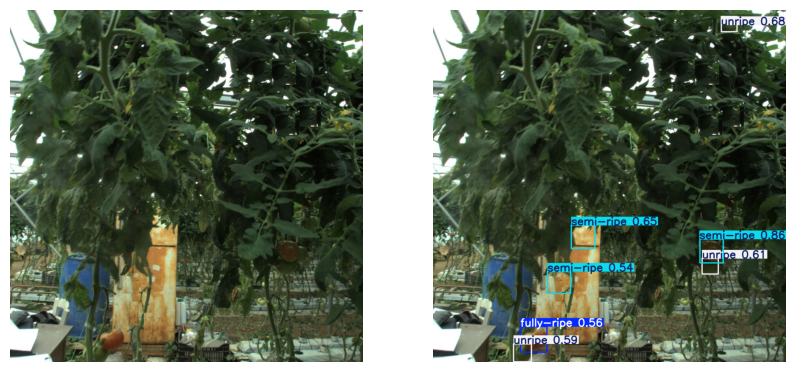

[img_b64 정보]
타입 (type): <class 'str'>
길이 (length): 215860 문자
앞 50자: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBw
뒤 50자: VzvUz/AMbKQOrGrc7XJt5CJlJAziqXdMXck9c5qJST0h8aP//Z


In [123]:
# image to Base64

PROJECT_ROOT = Path(find_project_root())

env_path = get_project_path(".env")
img = get_project_path("notebook", "data", "tomato_farm.jpg")
img_error = get_project_path("notebook", "data", "tomato_error.png")
user_request = "semi-ripe 토마토를 찾고, 바운딩 박스를 그린 이미지를 저장해주세요."
img_b64 = encode_image_to_base64(img, 80, 1024)

#display(Image.open(img).resize((512, 512)))
#display(Image.open(img_error).resize((512, 512)))
# 나란히 두 이미지 표시
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(Image.open(img))
axes[0].axis('off')
axes[1].imshow(Image.open(img_error))
axes[1].axis('off')
plt.show()

# img_b64 형태와 길이 출력
print("=" * 60)
print("[img_b64 정보]")
print("=" * 60)
print(f"타입 (type): {type(img_b64)}")
print(f"길이 (length): {len(img_b64)} 문자")
print(f"앞 50자: {img_b64[:50]}")
print(f"뒤 50자: {img_b64[-50:]}")
print("=" * 60)

In [99]:
import inspect, vision_agent.tools.tools as mod
print(inspect.getsource(mod.countgd_object_detection)[:1200])

def countgd_object_detection(
    prompt: str,
    image: np.ndarray,
    box_threshold: float = 0.23,
) -> List[Dict[str, Any]]:
    """'countgd_object_detection' is a tool that can detect multiple instances of an
    object given a text prompt. It is particularly useful when trying to detect and
    count a large number of objects. You can optionally separate object names in the
    prompt with commas. It returns a list of bounding boxes with normalized
    coordinates, label names and associated confidence scores.

    Parameters:
        prompt (str): The object that needs to be counted.
        image (np.ndarray): The image that contains multiple instances of the object.
        box_threshold (float, optional): The threshold for detection. Defaults
            to 0.23.

    Returns:
        List[Dict[str, Any]]: A list of dictionaries containing the score, label, and
            bounding box of the detected objects with normalized coordinates between 0
            and 1 (xmin, ymi

In [103]:
def load_visionagent_tools_strict() -> List[Dict[str, Any]]:
    mod = importlib.import_module("vision_agent.tools.tools")
    tools: List[Dict[str, Any]] = []
    for name, obj in inspect.getmembers(mod):
        if not inspect.isfunction(obj) or name.startswith("_"):
            continue

        # 1) tools.py에 "정의된" 함수만 (재export된 표준함수 제거)
        if getattr(obj, "__module__", None) != mod.__name__:
            continue

        doc = inspect.getdoc(obj) or ""

        # 2) '... is a tool' 패턴만 통과 (유틸 제거)
        #    (원하면 조건 완화 가능)
        if " is a tool" not in doc:
            continue

        tools.append({
            "name": name,
            "qualname": f"{mod.__name__}.{name}",
            "type": "function",
            "signature": str(inspect.signature(obj)),
            "doc": doc,
        })
    return tools

In [101]:
# 1. 함수 자체 정보
print("Function name:", mod.countgd_object_detection.__name__)
print("Function doc:", mod.countgd_object_detection.__doc__)
print("Function module:", mod.countgd_object_detection.__module__)

# 2. Vision Agent의 tool registry에서 metadata 확인
tools = load_visionagent_tools_strict()
for tool in tools:
    if tool["name"] == "countgd_object_detection":
        print("Tool metadata:", tool)
        break

Function name: countgd_object_detection
Function doc: 'countgd_object_detection' is a tool that can detect multiple instances of an
    object given a text prompt. It is particularly useful when trying to detect and
    count a large number of objects. You can optionally separate object names in the
    prompt with commas. It returns a list of bounding boxes with normalized
    coordinates, label names and associated confidence scores.

    Parameters:
        prompt (str): The object that needs to be counted.
        image (np.ndarray): The image that contains multiple instances of the object.
        box_threshold (float, optional): The threshold for detection. Defaults
            to 0.23.

    Returns:
        List[Dict[str, Any]]: A list of dictionaries containing the score, label, and
            bounding box of the detected objects with normalized coordinates between 0
            and 1 (xmin, ymin, xmax, ymax). xmin and ymin are the coordinates of the
            top-left and x

In [106]:
print("tool_registry sample keys:", list(tool_registry.keys()))
print("tool:", len(tool_registry))
print("sam2 in tool_registry:", "sam2" in tool_registry)

tool_registry sample keys: ['agentic_activity_recognition', 'agentic_document_extraction', 'agentic_object_detection', 'agentic_sam2_instance_segmentation', 'agentic_sam2_video_tracking', 'claude35_text_extraction', 'countgd_object_detection', 'countgd_sam2_instance_segmentation', 'countgd_sam2_video_tracking', 'countgd_sam2_visual_instance_segmentation', 'countgd_visual_object_detection', 'custom_object_detection', 'custom_od_sam2_video_tracking', 'depth_pro', 'detr_segmentation', 'document_extraction', 'document_qa', 'florence2_object_detection', 'florence2_ocr', 'florence2_sam2_instance_segmentation', 'florence2_sam2_video_tracking', 'generate_pose_image', 'glee_object_detection', 'glee_sam2_instance_segmentation', 'glee_sam2_video_tracking', 'owlv2_object_detection', 'owlv2_sam2_instance_segmentation', 'owlv2_sam2_video_tracking', 'qwen25_vl_images_vqa', 'qwen25_vl_video_vqa', 'qwen2_vl_images_vqa', 'qwen2_vl_video_vqa', 'sam2', 'siglip_classification', 'template_match', 'vit_image

* VQA

In [4]:
# tag parser

import json
import re
from typing import Any, Dict, Tuple

_TAG_RE = re.compile(
    r"<(?P<tag>analysis_log|plan_json)>(?P<body>[\s\S]*?)</(?P=tag)>",
    re.IGNORECASE,
)

def parse_tagged_output(text: str) -> Tuple[str, Dict[str, Any]]:
    """
    LLM 응답에서 <analysis_log>와 <plan_json>을 추출하고,
    plan_json은 JSON으로 파싱해서 dict로 반환
    """
    text = (text or "").strip()
    matches = {m.group("tag").lower(): m.group("body").strip() for m in _TAG_RE.finditer(text)}

    if "analysis_log" not in matches:
        raise ValueError("응답에 <analysis_log>...</analysis_log> 태그가 없습니다.")
    if "plan_json" not in matches:
        raise ValueError("응답에 <plan_json>...</plan_json> 태그가 없습니다.")

    analysis_log = matches["analysis_log"]
    plan_json_str = matches["plan_json"]

    try:
        plan = json.loads(plan_json_str)
    except json.JSONDecodeError as e:
        raise ValueError(f"<plan_json> 내부 JSON 파싱 실패: {e}\n\nJSON:\n{plan_json_str}")

    return analysis_log, plan

In [112]:
# VQA 프롬프트
PROMPT_VQA_TEMPLATE = """
You are an expert vision task planner.

You will be given:
- A user request (Korean)
- ONE image (provided to you as an image input)

Your job in this step is ONLY to analyze the user request and propose a concrete, tool-agnostic plan.
Do NOT run code. Do NOT claim results. Do NOT hallucinate object counts.

User request: {user_request}

Output MUST contain EXACTLY TWO TAGS in this order:
1) <analysis_log> ... </analysis_log>  (Korean, human-readable, step-by-step, short)
2) <plan_json> ... </plan_json>        (machine-readable, MUST be valid JSON)

Rules:
- Do not output anything outside the two tags.
- <analysis_log> should be concise: 5–10 lines, each starting with "Step N:".
- <plan_json> must be STRICT JSON (no trailing commas, no comments, no markdown).

<plan_json> JSON schema:
{{
  "language": "ko",
  "intent_summary": string,
  "task_type": "counting",
  "target_definition": {{
    "primary_object": "tomato",
    "required_attributes": ["red"],
    "exclusions": [string],
    "edge_cases": [string]
  }},
  "subtasks": [
    {{
      "name": string,
      "goal": string,
      "suggested_method": string
    }}
  ],
  "tool_requirements": {{
    "needs_localization": boolean,
    "needs_instance_separation": boolean,
    "needs_attribute_reasoning": boolean,
    "preferred_outputs": [string]
  }},
  "verification_checks": [string],
  "questions_if_ambiguous": [string]
}}
"""

In [7]:
# LLM-VQA 호출 및 첫번째 응답 파싱
from typing import Optional, Union
from anthropic import Anthropic

def model_response_anthropic(
    anthropic_client: Anthropic,
    prompt_text: str,
    model: str = "claude-sonnet-4-20250514",
    temperature: float = 0.1,
    max_tokens: int = 1000,
    parse_tags: bool = True,
    print_log: bool = True,
    # 이미지 입력(선택)
    img_b64: Optional[str] = None,
    media_type: str = "image/png",
) -> Union[str, Dict[str, Any]]:
    """
    Anthropic(Claude) 전용.
    - prompt_text: prompt1 (태그 출력 규칙 포함)
    - img_b64/media_type

    Returns:
      - parse_tags=False: raw string
      - parse_tags=True: dict {"raw": str, "analysis_log": str, "plan": dict}
    """
    # content 파트 구성
    content = [{"type": "text", "text": prompt_text}]

    if img_b64 is not None:
        content.append({
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": media_type,
                "data": img_b64,
            }
        })

    resp = anthropic_client.messages.create(
        model=model,
        max_tokens=max_tokens,
        temperature=temperature,
        messages=[{"role": "user", "content": content}],
    )

    # Claude 응답은 content blocks로 옴 → text block만 합치기
    raw = "".join(
        blk.text for blk in resp.content
        if getattr(blk, "type", None) == "text"
    ).strip()

    if not parse_tags:
        return raw

    analysis_log, plan = parse_tagged_output(raw)

    if print_log:
        print("\n[analysis_log]\n" + analysis_log)

    return {"raw": raw, "analysis_log": analysis_log, "plan": plan}


In [ ]:
# 실행
def run_vqa(state: AgentState, anthropic_client: Anthropic, prompt_VQA: str) -> AgentState:
    prompt = prompt_VQA.format(user_request=state.user_request)
    out = model_response_anthropic(
        anthropic_client=anthropic_client,
        prompt_text=prompt,
        img_b64=state.img_b64,
        media_type="image/jpeg",  # 추가: JPEG 형식 명시
    )
    state.vqa_log = out["analysis_log"]
    state.vqa_struct = out["plan"]
    return state

In [11]:
# LLM 호출 및 응답 생성, 확인
import os
from anthropic import Anthropic

anthropic_key  = os.getenv("ANTHROPIC_API_KEY")
if not anthropic_key:
    raise RuntimeError("ANTHROPIC_API_KEY가 설정되어 있지 않습니다.")

anthropic_client = Anthropic(api_key=anthropic_key)

out_vqa = model_response_anthropic(
    anthropic_client=anthropic_client,
    prompt_text=PROMPT_VQA_TEMPLATE,
    model="claude-sonnet-4-20250514",
    max_tokens=1200,
    temperature=0,
    parse_tags=True,
    print_log=True,
    img_b64=img_b64,    
    media_type="image/jpeg", 
)

vqa = out_vqa["plan"]


[analysis_log]
Step 1: 사용자가 토마토 개수를 세는 것을 요청했습니다.
Step 2: 이미지에서 토마토 식물들이 온실이나 농장 환경에서 자라고 있는 것을 확인했습니다.
Step 3: 잎사귀가 많고 밀집되어 있어 토마토 열매를 찾기 어려운 상황입니다.
Step 4: 빨간색으로 익은 토마토와 초록색 미성숙 토마토를 구분해야 합니다.
Step 5: 개별 토마토 인스턴스를 분리하고 정확한 위치를 파악해야 합니다.
Step 6: 잎이나 다른 식물 부분과 토마토를 구별하는 것이 중요합니다.
Step 7: 부분적으로 가려진 토마토들도 고려해야 합니다.


In [110]:
# vqa 결과 
vqa_log = out_vqa["analysis_log"]
vqa_struct = out_vqa["plan"]

# vqa_struct를 JSON 형태로 보기 좋게 출력
print("=" * 60)
print("[VQA Plan Structure (JSON)]")
print("=" * 60)
print(json.dumps(vqa_struct, indent=2, ensure_ascii=False))

[VQA Plan Structure (JSON)]
{
  "language": "ko",
  "intent_summary": "이미지에서 토마토의 개수를 정확히 세기",
  "task_type": "counting",
  "target_definition": {
    "primary_object": "토마토",
    "required_attributes": [
      "둥근 형태",
      "토마토 특유의 색상"
    ],
    "exclusions": [
      "잎사귀",
      "줄기",
      "꽃",
      "다른 식물 부분"
    ],
    "edge_cases": [
      "부분적으로 가려진 토마토",
      "미성숙한 초록색 토마토",
      "겹쳐진 토마토"
    ]
  },
  "subtasks": [
    {
      "name": "토마토 객체 탐지",
      "goal": "이미지에서 모든 토마토 위치 식별",
      "suggested_method": "객체 탐지 모델을 사용하여 토마토 후보 영역 찾기"
    },
    {
      "name": "개별 인스턴스 분리",
      "goal": "겹치거나 인접한 토마토들을 개별적으로 구분",
      "suggested_method": "인스턴스 세그멘테이션으로 각 토마토의 경계 구분"
    },
    {
      "name": "성숙도별 분류",
      "goal": "빨간 토마토와 초록 토마토 구분",
      "suggested_method": "색상 분석을 통한 성숙도 판별"
    },
    {
      "name": "최종 개수 계산",
      "goal": "탐지된 모든 토마토의 총 개수 산출",
      "suggested_method": "검증된 토마토 인스턴스들의 합계 계산"
    }
  ],
  "tool_requirements": {
    "needs_localization":

* Plan

In [ ]:
# 도구 설명 생성
def format_tool_desc(
    tools: List[Dict[str, Any]],
    max_tools: int = 50,
    max_doc_chars: int = 300,
) -> str:
    lines = []
    for t in tools[:max_tools]:
        lines.append(
            f"- {t['name']} ({t['type']})\n"
            f"  qualname: {t['qualname']}\n"
            f"  signature: {t['signature']}\n"
            f"  doc: {t['doc'][:max_doc_chars].replace('\\n', ' ')}"
        )
    return "\n".join(lines)

In [ ]:
# prompt_plan TEMPLATE
PROMPT_PLAN_TEMPLATE = """
You are a VisionAgent-style planner/controller.

Your job is to decide the NEXT ACTION(s) to take using the available tools, based on the user's request and the accumulated evidence. You do NOT execute tools. You only output tool calls or the final answer.

You will be given:
- A user request (Korean)
- ONE image (already annotated with detection boxes/labels overlaid)
- Tool list with available actions
- VQA log: chronological reasoning, detection notes, bounding-box/label evaluations, and any prior validation outcomes
- VQA structured JSON summary of the detection/analysis results
- Prior tool observations may also appear in the conversation history (as "observation").

Primary evidence:
- Build decisions primarily from [VQA_LOG] and [VQA_STRUCT_JSON].
- Do NOT hallucinate new detections, boxes, or attributes beyond the provided evidence and tool outputs.

User request (Korean):
{user_request}

[VQA_LOG]
{vqa_log}

[VQA_STRUCT_JSON]
{vqa_struct_json}

[TOOLS]
{tool_desc}

[OBSERVATIONS]
{observations}

────────────────────────────────
CORE CONTROL LOOP BEHAVIOR
────────────────────────────────
At each turn, output either:
(A) Tool calls for the NEXT immediate actions (one or more tool calls), OR
(B) A final answer if no more tools are needed.

Do NOT output a full end-to-end plan. Do NOT output steps[1..N].
The executor will run your tool calls in the order you provide, append observations, and call you again with updated context.

────────────────────────────────
DETECTION-SPECIFIC BEHAVIOR
────────────────────────────────
- The image is already annotated. Prefer verification of existing detections.
- If bounding-box coordinates are available in VQA_STRUCT_JSON, use them for cropping and verification.
- If bounding-box coordinates are NOT available, do NOT guess. Request the annotation file
  (COCO JSON / YOLO TXT / model output JSON) or propose a concrete method to obtain coordinates.

Hard rule:
- If VQA_STRUCT_JSON contains bbox coordinates, you MUST call the crop tool first for those boxes.
- You MUST NOT call any VQA tool before attempting crop-based verification when bbox coordinates exist.
- VQA tools are allowed ONLY if bbox coordinates are missing/unavailable OR cropping fails with an error.

────────────────────────────────
OUTPUT FORMAT (STRICT)
────────────────────────────────
Output MUST contain EXACTLY TWO tags in this exact order:
1) <analysis_log> ... </analysis_log>
2) <plan_json> ... </plan_json>

Do NOT output anything outside the two tags.

<analysis_log> rules:
- 3–7 lines only
- Each line must start with "Step N:"
- Only describe the immediate reasoning for the NEXT action(s), not a full multi-step plan.

<plan_json> rules:
- MUST be STRICT JSON (no trailing commas, no comments, no markdown)
- Must match exactly one of the following schemas:

Schema 1: Tool calls
{{
  "language": "ko",
  "mode": "tool_calls",
  "selected_tools": [string],
  "tool_calls": [
    {{
      "id": int,
      "tool": string,
      "parameters": object,
      "expected_result": string
    }}
  ],
  "open_questions": [string]
}}

Schema 2: Final answer
{{
  "language": "ko",
  "mode": "final",
  "final_answer": string,
  "open_questions": [string]
}}

Additional rules:
- tool_calls must be listed in exact execution order; ids must start at 1 and increase strictly by 1 within this turn.
- Each tool call MUST reference a tool name from [TOOLS].
- Keep tool_calls minimal: only what is needed before the next observation.
- If you need missing inputs (e.g., box coordinates), set mode="final" and clearly request them in final_answer, or set open_questions accordingly.
"""


In [ ]:
# prompt plan rendering
def render_prompt(user_request: str, vqa_log: str, vqa_struct: dict, tool_desc: str) -> str:
    vqa_struct_json = json.dumps(vqa_struct, ensure_ascii=False, indent=2)

    # observations는 너무 길어질 수 있으니, 필요하면 truncate 가능
    if planner_state["observations"]:
        obs_text = json.dumps(planner_state["observations"], ensure_ascii=False, indent=2)
    else:
        obs_text = "(none)"

    return PROMPT_PLAN_TEMPLATE.format(
        user_request=user_request,
        vqa_log=vqa_log,
        vqa_struct_json=vqa_struct_json,
        tool_desc=tool_desc,
        observations=obs_text,
    )

In [ ]:
# plan mode checking
def validate_plan(plan: dict, tools_meta: list[dict]) -> None:
    names = {t["name"] for t in tools_meta}
    mode = plan.get("mode")
    if mode not in ("tool_calls", "final"):
        raise ValueError(f"Invalid mode: {mode}")

    if mode == "tool_calls":
        for tc in plan.get("tool_calls", []):
            if tc.get("tool") not in names:
                raise ValueError(f"Unknown tool in plan: {tc.get('tool')}")

In [107]:
# tool 결과 누적
planner_state = {
    "observations": [],   # tool 결과 누적
    "turn": 0,
}

def add_observation(tool: str, params: dict, result, ok: bool = True, error: str | None = None):
    planner_state["observations"].append({
        "tool": tool,
        "parameters": params,
        "ok": ok,
        "result": result,
        "error": error,
    })

In [ ]:
# 계획 생성- 디버깅
def plan_once(user_request: str, vqa_log: str, vqa_struct: dict, tool_desc: str, img_b64: str):
    prompt_text = render_prompt(user_request, vqa_log, vqa_struct, tool_desc)

    out_plan = model_response_anthropic(
        anthropic_client=anthropic_client,
        prompt_text=prompt_text,
        model="claude-sonnet-4-20250514",
        max_tokens=1400,
        temperature=0.2,
        parse_tags=True,
        print_log=True,
        img_b64=img_b64,
        media_type="image/jpeg",
    )

    analysis_log = out_plan["analysis_log"]
    plan_json = out_plan["plan"]
    return analysis_log, plan_json


In [113]:
# 계획 생성
def plan_next(
    state: AgentState,
    anthropic_client: Anthropic,
    PROMPT_PLAN_TEMPLATE: str,
) -> Dict[str, Any]:
    prompt = PROMPT_PLAN_TEMPLATE.format(
        user_request=state.user_request,
        vqa_log=state.vqa_log,
        vqa_struct_json=json.dumps(state.vqa_struct, ensure_ascii=False, indent=2),
        tool_desc=state.tool_desc,
        observations=json.dumps(state.observations, ensure_ascii=False, indent=2),
    )
    out = model_response_anthropic(
        anthropic_client=anthropic_client,
        prompt_text=prompt,
        img_b64=state.img_b64,
    )
    state.all_plans.append(out["plan"])
    return out["plan"]

In [43]:
# plan 생성 (render_prompt + plan_once 내부 사용)
analysis_log, plan_struct = plan_once(
    user_request=user_request,
    vqa_log=vqa_log,
    vqa_struct=vqa_struct,
    tool_desc=tool_desc,
    img_b64=img_b64,
)

print("\n" + "=" * 60)
print("[Plan Structure (JSON)]")
print("=" * 60)
print(json.dumps(plan_struct, indent=2, ensure_ascii=False))



[analysis_log]
Step 1: 사용자가 semi-ripe 토마토를 찾고 바운딩 박스를 그린 이미지를 저장하라고 요청했습니다.
Step 2: VQA 로그에서는 토마토 개수 세기에 대한 분석이 있었지만, 현재 요청은 semi-ripe 토마토 탐지입니다.
Step 3: VQA_STRUCT_JSON에 바운딩 박스 좌표가 없으므로 객체 탐지 도구를 사용해야 합니다.
Step 4: semi-ripe 토마토는 완전히 익지 않은 상태로 부분적으로 색이 변한 토마토를 의미합니다.
Step 5: countgd_object_detection을 사용하여 semi-ripe 토마토를 탐지하겠습니다.

[Plan Structure (JSON)]
{
  "language": "ko",
  "mode": "tool_calls",
  "selected_tools": [
    "countgd_object_detection"
  ],
  "tool_calls": [
    {
      "id": 1,
      "tool": "countgd_object_detection",
      "parameters": {
        "prompt": "semi-ripe tomato, partially ripe tomato, orange tomato, yellow-green tomato",
        "image": "image",
        "box_threshold": 0.2
      },
      "expected_result": "semi-ripe 토마토들의 바운딩 박스와 위치 정보를 반환"
    }
  ],
  "open_questions": [
    "탐지된 결과를 바탕으로 바운딩 박스가 그려진 이미지를 생성해야 합니다"
  ]
}


* Executing

In [ ]:
# tool 실행
def _pretty(obj: Any, max_chars: int = 2000) -> str:
    try:
        s = json.dumps(obj, ensure_ascii=False, indent=2)
    except Exception:
        s = str(obj)
    if len(s) > max_chars:
        return s[:max_chars] + "\n...(truncated)..."
    return s


def run_tool_call(
    tc: Dict[str, Any],
    tool_registry: Dict[str, Dict[str, Any]],
    verbose: bool = False,
) -> Dict[str, Any]:
    tool_name = tc["tool"]
    params = tc.get("parameters", {}) or {}

    if tool_name not in tool_registry:
        raise KeyError(f"Tool not found in registry: {tool_name}")

    tool = tool_registry[tool_name]
    func = tool.get("func")
    if not callable(func):
        raise TypeError(f"Tool '{tool_name}' has no callable func")

    if verbose:
        print("\n" + "-" * 80)
        print(f"[RUN TOOL] id={tc.get('id')} tool={tool_name}")
        print("-" * 80)
        print("TOOL:", tool_name)
        print("PARAM TYPES:", {k: type(v) for k, v in params.items()})

    raw_result = func(**params)
    
    
    if verbose:
        print("RAW RESULT TYPE:", type(raw_result))

    # result를 항상 dict로 래핑
    if isinstance(raw_result, dict):
        result = raw_result
    else:
        result = {"result": raw_result}

    wrapped = {"tool": tool_name, "ok": True, **result}

    if verbose:
        print(_pretty(wrapped))

    return wrapped


In [ ]:
# tool 실행을 위한 이미지 처리
def b64_to_np(img_b64: str) -> np.ndarray:
    data = base64.b64decode(img_b64)
    img = Image.open(io.BytesIO(data)).convert("RGB")
    arr = np.array(img)
    assert isinstance(arr, np.ndarray)
    assert arr.ndim == 3 and arr.shape[2] == 3
    return arr

IMG_NP = b64_to_np(img_b64)  # 한번만 만들어서 재사용

def replace_image_placeholder(x):
    # 문자열 "image"면 실제 이미지로 치환
    if x == "image":
        return IMG_NP

    # 리스트면 원소별 치환
    if isinstance(x, list):
        return [replace_image_placeholder(v) for v in x]

    # 딕셔너리면 값들 치환
    if isinstance(x, dict):
        return {k: replace_image_placeholder(v) for k, v in x.items()}

    # 그 외는 그대로
    return x

*  Agentic Loop

In [ ]:
# Agentic Loop

max_turns = 4

final_answer = None
all_plans = []
all_execs = []

for turn in range(1, max_turns + 1):
    print("\n" + "=" * 80)
    print(f"[TURN {turn}] planning...")
    print("=" * 80)

    analysis_log, plan_json = plan_once(user_request, vqa_log, vqa_struct, tool_desc, img_b64)
    all_plans.append(plan_json)

    if plan_json.get("mode") == "final":
        final_answer = plan_json.get("final_answer")
        print("\n[FINAL]")
        print(final_answer)
        break

    tool_calls = plan_json.get("tool_calls", [])
    if not tool_calls:
        final_answer = "ERROR: mode=tool_calls but no tool_calls returned"
        print(final_answer)
        break

    for tc in tool_calls:
        print("\n" + "-" * 80)
        print(f"[RUN TOOL] id={tc.get('id')} tool={tc.get('tool')}")
        print("-" * 80)

        # tool 실행 직전: tc마다 치환
        params = tc.get("parameters", {}) or {}

        # placeholder 치환
        if params.get("image") == "image":
            params["image"] = b64_to_np(img_b64)

        if params.get("images") == ["image"]:
            params["images"] = [b64_to_np(img_b64)]

        # detected_image_crop이면 image_np 강제 주입
        if tc.get("tool") == "detected_image_crop":
            params["image_np"] = b64_to_np(img_b64)
            params["bbox_format"] = "xyxy_norm" 
            if "full_image_path" in params:
                params["full_image_path"] = None

        tc["parameters"] = params

        print("TOOL:", tc["tool"])
        print("PARAM TYPES:", {k: type(v) for k, v in tc["parameters"].items()})

        exec_result = run_tool_call(tc, tool_registry)
        all_execs.append(exec_result)

        # obsevation 누적
        planner_state["observations"].append(exec_result)

        try:
            s = json.dumps(exec_result, ensure_ascii=False, indent=2)
        except Exception:
            s = str(exec_result)
        print(s[:2000] + ("\n...(truncated)..." if len(s) > 2000 else ""))

if final_answer is None:
    print("\n[INFO] max_turns reached. Loop finished without final answer.")


[TURN 1] planning...

[analysis_log]
Step 1: 사용자가 semi-ripe 토마토를 찾고 바운딩 박스를 그린 이미지 저장을 요청했습니다.
Step 2: VQA_STRUCT_JSON에 바운딩 박스 좌표가 없으므로 먼저 토마토 객체 탐지를 수행해야 합니다.
Step 3: 이미지에서 토마토 식물들이 보이므로 객체 탐지 도구를 사용하여 모든 토마토를 찾아야 합니다.
Step 4: Semi-ripe 토마토는 녹색에서 빨간색으로 변해가는 중간 단계이므로 상세한 프롬프트가 필요합니다.
Step 5: countgd_object_detection을 사용하여 다양한 성숙도의 토마토들을 탐지하겠습니다.

--------------------------------------------------------------------------------
[RUN TOOL] id=1 tool=countgd_object_detection
--------------------------------------------------------------------------------
TOOL: countgd_object_detection
PARAM TYPES: {'prompt': <class 'str'>, 'image': <class 'numpy.ndarray'>, 'box_threshold': <class 'float'>}
{
  "tool": "countgd_object_detection",
  "ok": true,
  "result": [
    {
      "label": "green tomato",
      "bbox": [
        0.808,
        0.232,
        0.861,
        0.32
      ],
      "score": 0.37
    },
    {
      "label": "green tomato",
      "bbox": [
        0.677,
        0.104,
      

* Code generation

In [ ]:
# 최종 코드를 작성의 과정을 계획하기 위한 프롬프트
PROMPT_FINAL_PLAN_TEMPLATE = """
You are a code planning expert. Your job is to create a detailed, step-by-step execution plan for generating Python code.

You will be given:
- A user request (Korean)
- VQA analysis results (what was understood from the image and request)
- Tool execution observations (what tools were run and their results)
- Available tools list

Your task:
Create a final execution plan that lists the exact steps needed to write Python code to complete the task.

User request: {user_request}

[VQA ANALYSIS]
{vqa_log}

[VQA STRUCTURED SUMMARY]
{vqa_struct_json}

[TOOL OBSERVATIONS]
{observations}

[AVAILABLE TOOLS]
{tool_desc}

────────────────────────────────
OUTPUT FORMAT (STRICT)
────────────────────────────────
Output MUST contain EXACTLY TWO tags in this exact order:
1) <final_answer> ... </final_answer>
2) <code_plan> ... </code_plan>

<final_answer> rules:
- Brief summary (1-2 sentences) of what the code will accomplish
- Written in Korean

<code_plan> rules:
- MUST be STRICT JSON array
- Each element represents one execution step
- Steps must be in exact execution order
- Format:
[
  {{
    "step": 1,
    "instruction": "Brief instruction describing what to do",
    "code_snippet": "Example code (not full implementation, just example)",
    "explanation": "Why this step is needed (optional)"
  }},
  ...
]

Instruction guidelines:
- Be specific about which functions/tools to use
- Include parameter hints (e.g., "prompt 'tomato'")
- Each step should be a single, clear action
- Steps should build on each other logically

Example instruction format:
- "Load the image using load_image()"
- "Use countgd_object_detection with prompt 'tomato' to detect all tomato instances"
- "Count the number of detections by getting the length of the detection list"
- "Visualize the detections by overlaying bounding boxes using overlay_bounding_boxes()"
- "Save the visualization to a file using save_image()"

Do NOT output anything outside the two tags.
"""

In [ ]:
# 최종 코드 생성 계획 
def generate_final_plan(
    state: AgentState,
    anthropic_client: Anthropic,
    prompt_template: str = PROMPT_FINAL_PLAN_TEMPLATE,
    model: str = "claude-sonnet-4-20250514",
    temperature: float = 0.2,
    max_tokens: int = 1500,
) -> Dict[str, Any]:
    """
    최종 코드 생성 계획을 생성
    
    Returns:
        {
            "final_answer": str,
            "code_plan": List[Dict[str, Any]]
        }
    """
    prompt = prompt_template.format(
        user_request=state.user_request,
        vqa_log=state.vqa_log,
        vqa_struct_json=json.dumps(state.vqa_struct, ensure_ascii=False, indent=2),
        observations=json.dumps(state.observations, ensure_ascii=False, indent=2) if state.observations else "(none)",
        tool_desc=state.tool_desc,
    )
    
    out = model_response_anthropic(
        anthropic_client=anthropic_client,
        prompt_text=prompt,
        model=model,
        max_tokens=max_tokens,
        temperature=temperature,
        parse_tags=True,
        print_log=False,
        img_b64=state.img_b64,
        media_type="image/jpeg",
    )
    
    # 태그 파싱
    raw = out["raw"]
    
    # <final_answer> 태그 추출
    final_answer_match = re.search(r"<final_answer>(.*?)</final_answer>", raw, re.DOTALL | re.IGNORECASE)
    final_answer = final_answer_match.group(1).strip() if final_answer_match else ""
    
    # <code_plan> 태그 추출 및 JSON 파싱
    code_plan_match = re.search(r"<code_plan>(.*?)</code_plan>", raw, re.DOTALL | re.IGNORECASE)
    if not code_plan_match:
        raise ValueError("응답에 <code_plan>...</code_plan> 태그가 없습니다.")
    
    code_plan_str = code_plan_match.group(1).strip()
    try:
        code_plan = json.loads(code_plan_str)
    except json.JSONDecodeError as e:
        raise ValueError(f"<code_plan> 내부 JSON 파싱 실패: {e}\n\nJSON:\n{code_plan_str}")
    
    return {
        "final_answer": final_answer,
        "code_plan": code_plan,
        "raw": raw
    }

In [ ]:
# Utils: 최종 코드 디스플레이
from typing import List, Dict, Any

def format_code_plan_display(
    code_plan: List[Dict[str, Any]],
    width: int = 90,
    separator_token: str = "---",
) -> str:
    try:
        from rich.console import Console
        from rich.panel import Panel
        from rich.text import Text
        from rich.rule import Rule
        from rich import box
        from rich.console import Group  # 핵심: 여러 renderable을 묶어주는 컨테이너

        console = Console(
            width=width,
            record=True,
            force_terminal=True,
            color_system=None,
        )

        renderables = []
        for step in code_plan:
            inst = str(step.get("instruction", "")).strip()
            if not inst:
                continue

            parts = [p.strip() for p in inst.split(separator_token)]
            for i, part in enumerate(parts):
                if part:
                    renderables.append(Text(part))
                if i < len(parts) - 1:
                    renderables.append(Rule(characters="─"))

        if not renderables:
            renderables.append(Text("(empty)"))

        panel = Panel(
            Group(*renderables),   # 핵심: 리스트를 Group으로 감싸서 renderable로 만들기
            title="Instructions",
            box=box.SQUARE,
            expand=False,
        )

        console.print(panel)
        return console.export_text()

    except Exception:
        return _format_code_plan_display_fallback(
            code_plan,
            width=width,
            separator_token=separator_token,
        )


def _format_code_plan_display_fallback(
    code_plan: List[Dict[str, Any]],
    width: int = 90,
    separator_token: str = "---",   # 핵심: 시그니처에 추가
) -> str:
    lines = []
    lines.append("┏" + "━" * (width - 2) + "┓")
    lines.append("┃ Instructions" + " " * (width - 15) + "┃")
    lines.append("┡" + "━" * (width - 2) + "┩")

    for step in code_plan:
        inst = str(step.get("instruction", "")).strip()
        if not inst:
            continue

        parts = [p.strip() for p in inst.split(separator_token)]
        for pi, part in enumerate(parts):
            if part:
                words = part.split()
                cur = ""
                for w in words:
                    nxt = (cur + " " + w).strip()
                    if len(nxt) <= width - 4:
                        cur = nxt
                    else:
                        if cur:
                            padding = " " * (width - len(cur) - 3)
                            lines.append(f"│ {cur}{padding}│")
                        cur = w
                if cur:
                    padding = " " * (width - len(cur) - 3)
                    lines.append(f"│ {cur}{padding}│")

            # separator 출력
            if pi < len(parts) - 1:
                lines.append("│ " + "─" * (width - 4) + " │")

    lines.append("└" + "─" * (width - 2) + "┘")
    return "\n".join(lines)

def print_code_plan(
    code_plan: List[Dict[str, Any]],
    width: int = 100,
    separator_token: str = "---",
    truncate: bool = True,
):
    """
    - 각 instruction을 '항상 한 줄(행)'로 출력
    - separator_token(기본 '---')로 문장 분리 시 구분선 삽입
    - 두 번 출력되는 문제 방지: export_text를 print하지 않고 rich로만 출력
    """
    from rich.console import Console
    from rich.table import Table
    from rich import box
    from rich.rule import Rule

    console = Console(width=width, force_terminal=True, color_system=None)

    table = Table(
        title="Instructions",
        box=box.SQUARE,
        show_header=False,
        padding=(0, 1),
        width=width,
    )
    table.add_column("instruction", overflow="ellipsis" if truncate else "fold", no_wrap=truncate)

    def _add_line(line: str):
        line = line.strip()
        if not line:
            return
        table.add_row(line)

    for step in code_plan:
        inst = str(step.get("instruction", "")).strip()
        if not inst:
            continue

        parts = [p.strip() for p in inst.split(separator_token)]
        for i, part in enumerate(parts):
            if part:
                _add_line(part)
            if i < len(parts) - 1:
                # 구분선: Table 안에서 한 행으로 넣기
                _add_line("─" * (width - 6))

    console.print(table)

In [ ]:
# Utils: 최종 코드 저장
from pathlib import Path

def save_code_to_file(code: str, filename: str = "extract_code.py") -> Path:
    path = Path.cwd() / filename
    path.write_text(code, encoding="utf-8")
    return path


In [ ]:
# 최종 코드 생성 프롬프트 
def build_codegen_prompt(instruction: str, tool_desc: str = "", has_image: bool = False) -> str:
    img_note = (
        "- An image is provided via base64 (img_b64). Use it ONLY if your environment supports it.\n"
        if has_image else
        "- No image is directly embedded. Assume the script will load image_path from disk.\n"
    )

    return f"""
You are a coding assistant.
Write a SINGLE Python file that satisfies the instruction below.

Instruction:
{instruction}

Available tools (reference only):
{tool_desc}

Hard requirements:
- Output ONLY valid Python code (no markdown, no explanations).
- The file must be executable as a script.
- Provide: run(image_path: str) -> dict
- Include a __main__ block that calls run("image.png") by default.
{img_note}
- Include needed imports explicitly.
- Make it robust: basic error handling and clear variable names.
- Do NOT print the whole image or base64. Only print summary results.

Return only the code.
""".strip()


def strip_code_fences(text: str) -> str:
    t = text.strip()
    if t.startswith("```"):
        t = t.split("\n", 1)[-1]
        if t.endswith("```"):
            t = t.rsplit("```", 1)[0]
    return t.strip()


In [ ]:
# json 형태 계획 > txt 형태 계획 - 디버깅용
def code_plan_to_instruction(code_plan) -> str:
    if not code_plan:
        return ""
    return "\n".join(
        str(s.get("instruction", "")).strip()
        for s in code_plan
        if str(s.get("instruction", "")).strip()
    ).strip()

In [116]:
# 최종 코드 생성  
def generate_final_plan(
    state: AgentState,
    anthropic_client: Anthropic,
    prompt_template: str = PROMPT_FINAL_PLAN_TEMPLATE,
    model: str = "claude-sonnet-4-20250514",
    temperature: float = 0.2,
    max_tokens: int = 1500,
) -> Dict[str, Any]:
    """
    최종 코드 생성 계획을 생성
    
    Returns:
        {
            "final_answer": str,
            "code_plan": List[Dict[str, Any]]
        }
    """
    prompt = prompt_template.format(
        user_request=state.user_request,
        vqa_log=state.vqa_log,
        vqa_struct_json=json.dumps(state.vqa_struct, ensure_ascii=False, indent=2),
        observations=json.dumps(state.observations, ensure_ascii=False, indent=2) if state.observations else "(none)",
        tool_desc=state.tool_desc,
    )
    
    # parse_tags=False로 설정하여 raw 응답 받기
    out = model_response_anthropic(
        anthropic_client=anthropic_client,
        prompt_text=prompt,
        model=model,
        max_tokens=max_tokens,
        temperature=temperature,
        parse_tags=False,  # ← False로 변경
        print_log=False,
        img_b64=state.img_b64,
        media_type="image/jpeg",
    )
    
    # raw는 문자열이므로 직접 파싱
    raw = out if isinstance(out, str) else out.get("raw", "")
    
    # <final_answer> 태그 추출
    final_answer_match = re.search(r"<final_answer>(.*?)</final_answer>", raw, re.DOTALL | re.IGNORECASE)
    final_answer = final_answer_match.group(1).strip() if final_answer_match else ""
    
    if not final_answer_match:
        raise ValueError("응답에 <final_answer>...</final_answer> 태그가 없습니다.")
    
    # <code_plan> 태그 추출 및 JSON 파싱
    code_plan_match = re.search(r"<code_plan>(.*?)</code_plan>", raw, re.DOTALL | re.IGNORECASE)
    if not code_plan_match:
        raise ValueError("응답에 <code_plan>...</code_plan> 태그가 없습니다.")
    
    code_plan_str = code_plan_match.group(1).strip()
    try:
        code_plan = json.loads(code_plan_str)
    except json.JSONDecodeError as e:
        raise ValueError(f"<code_plan> 내부 JSON 파싱 실패: {e}\n\nJSON:\n{code_plan_str}")
    
    return {
        "final_answer": final_answer,
        "code_plan": code_plan,
        "raw": raw
    }

In [115]:
# 최종 코드 실행
def execute_plan(
    state: AgentState,
    plan_json: Dict[str, Any],
    verbose: bool = False,
) -> AgentState:
    tool_calls = plan_json.get("tool_calls", []) or []

    for tc in tool_calls:
        params = tc.get("parameters", {}) or {}

        # placeholder 치환 (LLM이 "image"라고 써둔 경우)
        if params.get("image") == "image":
            params["image"] = b64_to_np(state.img_b64)

        if params.get("images") == ["image"]:
            params["images"] = [b64_to_np(state.img_b64)]

        # agentic_object_detection 전용 prompt 정리 (추가)
        tool_name = tc.get("tool")
        if tool_name in ["agentic_object_detection", "agentic_sam2_instance_segmentation"]:
            prompt = params.get("prompt")
            if isinstance(prompt, str):
                # 콤마 기준으로 첫 번째만 사용
                prompt = prompt.split(",")[0]
                # 마침표 제거
                prompt = prompt.replace(".", " ")
                # 공백 정리
                params["prompt"] = prompt.strip()

        # detected_image_crop 전용 보정
        if tool_name == "detected_image_crop":
            params["image_np"] = b64_to_np(state.img_b64)
            params["bbox_format"] = "xyxy_norm"
            if "full_image_path" in params:
                params["full_image_path"] = None

        tc["parameters"] = params

        exec_result = run_tool_call(tc, state.tool_registry, verbose=verbose)
        state.all_execs.append(exec_result)
        state.observations.append(exec_result)

    return state

In [117]:
from dataclasses import dataclass
from typing import Dict, Any, Optional

@dataclass
class CodegenCoder:
    llm: "LLMClient"
    out_filename: str = "extract_code.py"
    model_name: Optional[str] = None

    def __call__(
        self,
        instruction: str,
        *,
        img_b64: Optional[str] = None,
        tool_desc: str = "",
        tool_registry: Optional[Dict[str, Any]] = None,
    ) -> Dict[str, Any]:
        prompt = build_codegen_prompt(
            instruction=instruction,
            tool_desc=tool_desc,
            has_image=bool(img_b64),
        )

        raw = self.llm.generate(prompt)
        code = strip_code_fences(raw)

        path = save_code_to_file(code, self.out_filename)

        return {
            "status": "success",
            "file": str(path),
            "code": code,
            "prompt": prompt,
            "model": self.model_name,
        }

In [ ]:
class AnthropicLLMClient:
    def __init__(self, anthropic_client, model: str):
        self.client = anthropic_client
        self.model = model

    def generate(self, prompt: str) -> str:
        resp = self.client.messages.create(
            model=self.model,
            max_tokens=2500,
            messages=[{"role": "user", "content": prompt}],
        )
        # resp.content: List[TextBlock]
        return "".join(block.text for block in resp.content if hasattr(block, "text"))


In [ ]:
def run_coder(state: "AgentState") -> "AgentState":
    if state.coder is None:
        raise RuntimeError("state.coder is None. Inject a coder instance before calling run_coder().")

    instruction = code_plan_to_instruction(state.code_plan) or state.user_request

    result = state.coder(
        instruction,
        img_b64=state.img_b64,
        tool_desc=state.tool_desc,
        tool_registry=state.tool_registry,
    )

    # state 업데이트(기록)
    state.coder_prompt = result.get("prompt")
    state.generated_code = result.get("code")
    state.generated_code_path = result.get("file")
    state.all_codes.append(result)

    return state

In [62]:
def run_agent_with_final_plan(
    state: AgentState,
    anthropic_client: Anthropic,
    PROMPT_PLAN_TEMPLATE: str,
    PROMPT_FINAL_PLAN_TEMPLATE: str,
    max_turns: int = 4,
    verbose: bool = True,
) -> AgentState:
    """
    Agent loop with final plan generation
    """
    for turn in range(1, max_turns + 1):
        if verbose:
            print("\n" + "=" * 80)
            print(f"[TURN {turn}] planning...")
            print("=" * 80)

        plan_json = plan_next(state, anthropic_client, PROMPT_PLAN_TEMPLATE)

        if plan_json.get("mode") == "final":
            # 일반 final answer인 경우, final plan 생성으로 전환
            if verbose:
                print("\n[GENERATING FINAL CODE PLAN...]")
                print("=" * 80)
            
            final_plan = generate_final_plan(
                state,
                anthropic_client,
                PROMPT_FINAL_PLAN_TEMPLATE,
            )
            
            state.final_answer = final_plan["final_answer"]
            state.code_plan = final_plan["code_plan"]
            
            if verbose:
                print("\n[FINAL ANSWER]")
                print(final_plan["final_answer"])
                print("\n[CODE GENERATION PLAN]")
                print_code_plan(final_plan["code_plan"])
            
            break

        if plan_json.get("mode") == "tool_calls":
            tool_calls = plan_json.get("tool_calls") or []
            if not tool_calls:
                state.final_answer = "ERROR: mode=tool_calls but no tool_calls returned"
                if verbose:
                    print(state.final_answer)
                break

            state = execute_plan(state, plan_json, verbose=verbose)

    if state.final_answer is None and verbose:
        print("\n[INFO] max_turns reached. Loop finished without final answer.")

    return state

In [82]:
def run_coder_after_final_plan(state, coder: CodegenCoder):
    instruction = code_plan_to_instruction(getattr(state, "code_plan", None)) or state.user_request
    result = coder(instruction, tool_desc=getattr(state, "tool_desc", ""))
    # state에 기록(필드가 있으면)
    if hasattr(state, "generated_code"):
        state.generated_code = result["code"]
    if hasattr(state, "generated_code_path"):
        state.generated_code_path = result["file"]
    if hasattr(state, "coder_prompt"):
        state.coder_prompt = result["prompt"]
    if hasattr(state, "all_codes"):
        state.all_codes.append(result)
    return state, result


Agent loop

In [71]:
anthropic_client = Anthropic(api_key=anthropic_key)

state = prepare_context(
    user_request="semi-ripe 토마토의 바운딩 박스 영역을 각각 알려주세요.",
    img_path="data/tomato_farm.jpg",
    tools=tools,   # load_visionagent_tools_strict() + crop tool 포함
)

state = run_vqa(state, anthropic_client, PROMPT_VQA_TEMPLATE)
state = run_agent_with_final_plan(
    state,
    anthropic_client,
    PROMPT_PLAN_TEMPLATE,
    PROMPT_FINAL_PLAN_TEMPLATE,
    max_turns=4,
    verbose=True
)

AnthropicLLMClient
print(state.final_answer)


[analysis_log]
Step 1: 사용자가 semi-ripe 토마토의 바운딩 박스 영역을 요청함
Step 2: 이미지에서 토마토 식물과 열매들을 확인할 수 있음
Step 3: semi-ripe는 반숙 상태로 녹색에서 빨간색으로 변해가는 중간 단계를 의미
Step 4: 각각의 semi-ripe 토마토를 개별적으로 식별하고 위치를 파악해야 함
Step 5: 바운딩 박스 좌표를 정확히 제공하기 위해 객체 탐지와 성숙도 분석이 필요
Step 6: 완전히 녹색이거나 완전히 빨간 토마토는 제외해야 함

[TURN 1] planning...

[analysis_log]
Step 1: 사용자가 semi-ripe 토마토의 바운딩 박스 영역을 요청했음
Step 2: VQA_STRUCT_JSON에서 바운딩 박스 좌표가 제공되지 않았음을 확인
Step 3: 이미지에서 토마토 식물과 열매들이 보이지만 정확한 좌표 정보가 없음
Step 4: semi-ripe 토마토를 탐지하기 위해 객체 탐지 도구를 사용해야 함
Step 5: agentic_object_detection을 사용하여 semi-ripe 상태의 토마토를 탐지하고 바운딩 박스 좌표를 얻어야 함

--------------------------------------------------------------------------------
[RUN TOOL] id=1 tool=agentic_object_detection
--------------------------------------------------------------------------------
TOOL: agentic_object_detection
PARAM TYPES: {'prompt': <class 'str'>, 'image': <class 'numpy.ndarray'>}
RAW RESULT TYPE: <class 'list'>
{
  "tool": "agentic_object_detection",
  "ok": true,
  "result": [

Instructions                                            
┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Load the image using load_image()                                                                │
│ Use agentic_object_detection with prompt 'semi-ripe tomato' to detect semi-ripe tomatoes         │
│ Extract and format bounding box coordinates for each semi-ripe tomato                            │
│ Convert normalized coordinates to pixel coordinates using image dimensions                       │
│ Visualize the detected semi-ripe tomatoes by overlaying bounding boxes using overlay_bounding_b… │
│ Create a summary report with all semi-ripe tomato bounding box information                       │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

이미지에서 semi-ripe 토마토를 탐지하여 각각의 바운딩 박스 좌표를 추출하고, 결과를 시각화하여 보여주는 코드를 작성합니다.


In [ ]:
from typing import List, Dict, Any

def format_code_plan_display(
    code_plan: List[Dict[str, Any]],
    width: int = 90,
    separator_token: str = "---",
) -> str:
    try:
        from rich.console import Console
        from rich.panel import Panel
        from rich.text import Text
        from rich.rule import Rule
        from rich import box
        from rich.console import Group  # 핵심: 여러 renderable을 묶어주는 컨테이너

        console = Console(
            width=width,
            record=True,
            force_terminal=True,
            color_system=None,
        )

        renderables = []
        for step in code_plan:
            inst = str(step.get("instruction", "")).strip()
            if not inst:
                continue

            parts = [p.strip() for p in inst.split(separator_token)]
            for i, part in enumerate(parts):
                if part:
                    renderables.append(Text(part))
                if i < len(parts) - 1:
                    renderables.append(Rule(characters="─"))

        if not renderables:
            renderables.append(Text("(empty)"))

        panel = Panel(
            Group(*renderables),   # 핵심: 리스트를 Group으로 감싸서 renderable로 만들기
            title="Instructions",
            box=box.SQUARE,
            expand=False,
        )

        console.print(panel)
        return console.export_text()

    except Exception:
        return _format_code_plan_display_fallback(
            code_plan,
            width=width,
            separator_token=separator_token,
        )


def _format_code_plan_display_fallback(
    code_plan: List[Dict[str, Any]],
    width: int = 90,
    separator_token: str = "---",   # 핵심: 시그니처에 추가
) -> str:
    lines = []
    lines.append("┏" + "━" * (width - 2) + "┓")
    lines.append("┃ Instructions" + " " * (width - 15) + "┃")
    lines.append("┡" + "━" * (width - 2) + "┩")

    for step in code_plan:
        inst = str(step.get("instruction", "")).strip()
        if not inst:
            continue

        parts = [p.strip() for p in inst.split(separator_token)]
        for pi, part in enumerate(parts):
            if part:
                words = part.split()
                cur = ""
                for w in words:
                    nxt = (cur + " " + w).strip()
                    if len(nxt) <= width - 4:
                        cur = nxt
                    else:
                        if cur:
                            padding = " " * (width - len(cur) - 3)
                            lines.append(f"│ {cur}{padding}│")
                        cur = w
                if cur:
                    padding = " " * (width - len(cur) - 3)
                    lines.append(f"│ {cur}{padding}│")

            # separator 출력
            if pi < len(parts) - 1:
                lines.append("│ " + "─" * (width - 4) + " │")

    lines.append("└" + "─" * (width - 2) + "┘")
    return "\n".join(lines)

In [84]:
llm = AnthropicLLMClient(anthropic_client, model="claude-sonnet-4-20250514") 
coder = CodegenCoder(llm=llm, out_filename="extract_code.py")
state, coder_result = run_coder_after_final_plan(state, coder)

print("saved:", coder_result["file"])

saved: c:\Users\KIST\agentic-visionai-qwen\notebook\extract_code.py


In [87]:
from pathlib import Path
proj_root = Path.cwd()
script = proj_root / "extract_code.py"

assert script.exists(), f"못 찾음: {script}"
!python "{script}"

Semi-ripe Tomato Detection Report
Image: data/tomato_farm.jpg
Image dimensions: 2000 x 2000
Total semi-ripe tomatoes detected: 1

Detection details:
  Tomato 1:
    - Confidence: 1.000
    - Pixel bbox: [486, 1812, 666, 1952]
    - Center: (576, 1882)
    - Size: 180 x 140 px


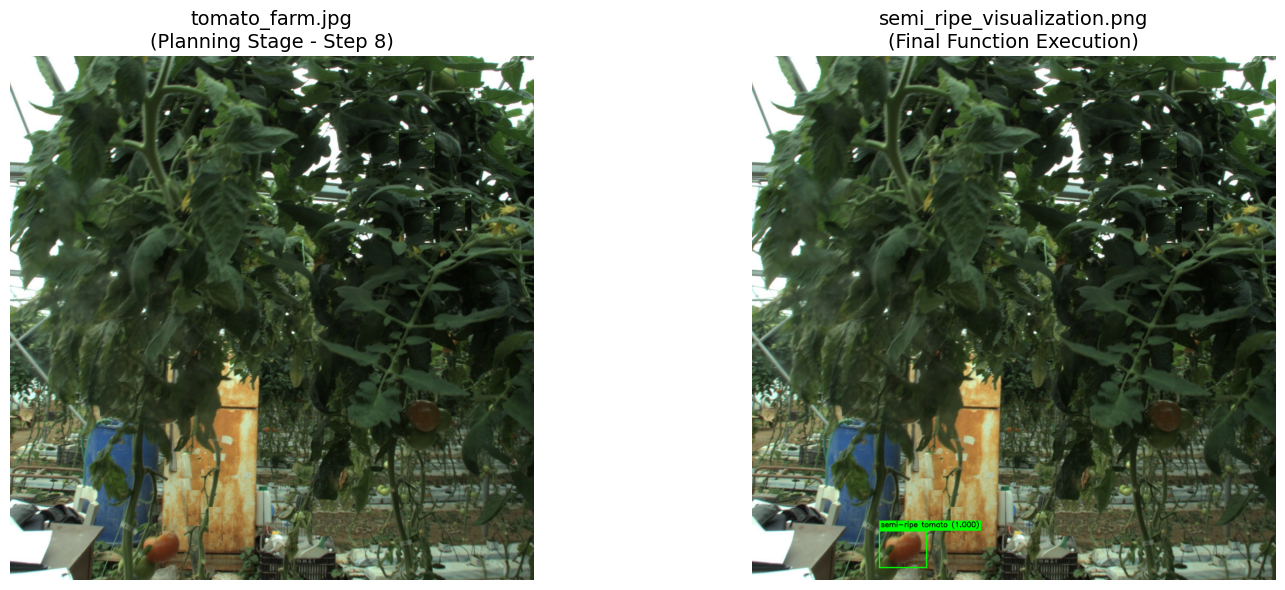

In [92]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def visualize_bbox(
    image_path: str,
    bbox: list,
    out_path: str = "semi_ripe_visualization.png",
    label: str = "semi-ripe tomato",
    conf: float = 1.0,
):
    import cv2

    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Failed to read image: {image_path}")

    x1, y1, x2, y2 = map(int, bbox)

    # bbox 그리기
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 4)

    # 라벨 텍스트
    text = f"{label} ({conf:.3f})"
    (tw, th), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)

    # 텍스트 배경 박스 (이미지 밖으로 나가지 않게)
    tx = x1
    ty = max(y1 - 10, th + 10)
    cv2.rectangle(img, (tx, ty - th - baseline), (tx + tw + 10, ty + baseline), (0, 255, 0), -1)
    cv2.putText(img, text, (tx + 5, ty - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)

    # 저장
    cv2.imwrite(out_path, img)
    return out_path


if __name__ == "__main__":
    visualize_bbox(
        image_path="data/tomato_farm.jpg",
        bbox=[486, 1812, 666, 1952],
        out_path="semi_ripe_visualization.png",
        label="semi-ripe tomato",
        conf=1.0,
    )

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. detected_tomatoes.png (Planning stage result)
img1 = Image.open("data/tomato_farm.jpg")
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title("tomato_farm.jpg\n(Planning Stage - Step 8)", fontsize=14)


# 2. detected_objects.png (Final function execution result)
img2 = Image.open("semi_ripe_visualization.png")
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title("semi_ripe_visualization.png\n(Final Function Execution)", fontsize=14)

plt.tight_layout()
plt.show()
